In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Automatically generating object masks with SAM

Since SAM can efficiently process prompts, masks for the entire image can be generated by sampling a large number of prompts over an image. This method was used to generate the dataset SA-1B. 

The class `SamAutomaticMaskGenerator` implements this capability. It works by sampling single-point input prompts in a grid over the image, from each of which SAM can predict multiple masks. Then, masks are filtered for quality and deduplicated using non-maximal suppression. Additional options allow for further improvement of mask quality and quantity, such as running prediction on multiple crops of the image or postprocessing masks to remove small disconnected regions and holes.

In [2]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_collab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

## Set-up

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [4]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))

In [5]:
import matplotlib.patches as patches
import matplotlib.path as path
import matplotlib as mpl

def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    # Define some hatch patterns
    hatches = ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*']

    for idx, ann in enumerate(sorted_anns):
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))

        # Create a mask using the segmentation
        mask = np.zeros_like(img)
        mask[m] = 1

        # Choose a hatch pattern based on the current index
        hatch = hatches[idx % len(hatches)]

        # Create a PathPatch from the mask and apply the hatch pattern
        mask_path = path.Path(mask)
        patch = patches.PathPatch(mask_path, hatch=hatch, fill=True)

        # Add the patch to the axes
        ax.add_patch(patch)


In [14]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    cmap = plt.cm.cividis  # Use the 'cividis' colormap
    norm = mpl.colors.Normalize(vmin=0, vmax=len(sorted_anns))
    for idx, ann in enumerate(sorted_anns):
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = cmap(norm(idx))[:3]  # Get a color from the colormap
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))


## Example image

In [6]:
image = cv2.imread('images/scene_2.png')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

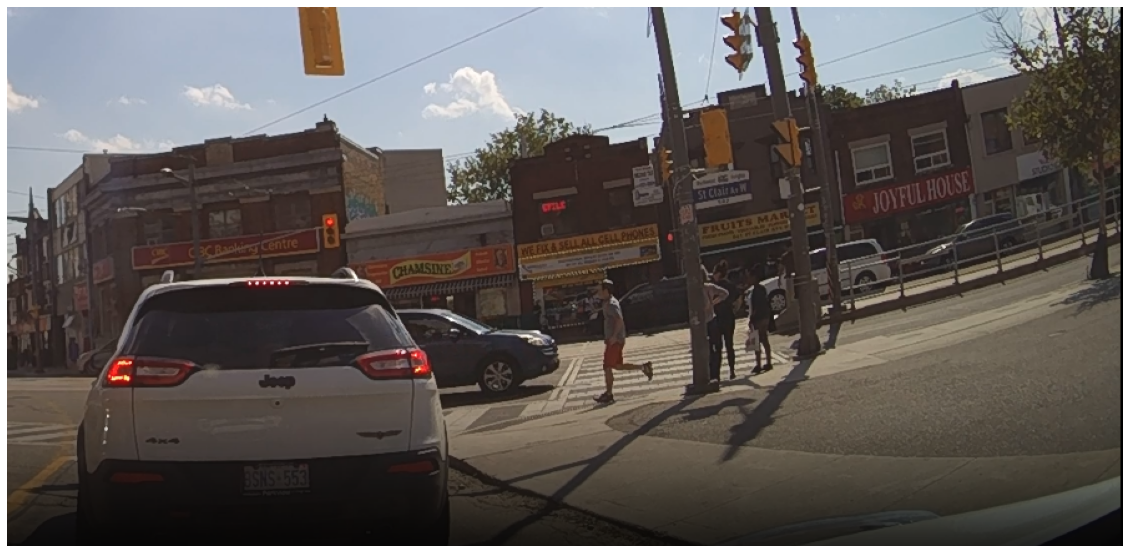

In [7]:
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

## Automatic mask generation
To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. 
### usage
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)
masks = mask_generator.generate(image) # a series of generated masks based on image

### masks content
Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

### objective
explain the masks content, with professional understanding in Computer vision field. 

The output of the `SamAutomaticMaskGenerator.generate(image)` is a list of dictionaries. Each dictionary represents a mask for an object in the image, and contains various attributes that give us further information about that mask and the object it represents:

* `segmentation`: This represents the binary mask itself, which typically will have the same dimensions as the input image. For each pixel in the image, the mask will have a value of 1 if that pixel is part of the object represented by the mask, and 0 otherwise. The mask can be used to isolate the object from the rest of the image for further analysis or processing.

* `area`: This is the total area of the mask, measured in pixels. This can be calculated by simply summing all the 1s in the binary mask. The area can give us an estimate of the size of the object in the image.

* `bbox`: The bounding box of the mask, given in XYWH format. This means the top-left corner's coordinates (X, Y) of the smallest box that can contain the object, and the width (W) and height (H) of that box. The bounding box is another way to estimate the size and location of the object in the image.

* `predicted_iou`: This is the Intersection over Union (IoU) score predicted by the model for the mask. IoU is a measure of the overlap between the predicted mask and the ground truth mask. A higher IoU score indicates a better quality mask.

* `point_coords`: This indicates the coordinates of the sampled input point that was used to generate this mask. In other words, it shows the point in the image where the model started when it generated the mask.

* `stability_score`: This is an additional measure of mask quality, which takes into account the variability of the mask in response to small changes in the input. A higher stability score indicates that the mask is more stable and reliable.

* `crop_box`: This is the crop of the image used to generate this mask, also given in XYWH format. This gives an idea of the portion of the image that the model focused on when generating the mask. It can be useful in understanding the context in which the object appears in the image.


In [8]:
sam_checkpoint = "/root/autodl-tmp/sam_vit_h_4b8939.pth"

device = "cuda"
model_type = "default"

In [9]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

To generate masks, just run `generate` on an image.

In [10]:
masks = mask_generator.generate(image)

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

In [11]:
print(len(masks))
print(masks[0].keys())

141
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


In [12]:
masks[1]['bbox']

[0, 0, 804, 194]

Show all the masks overlayed on the image.

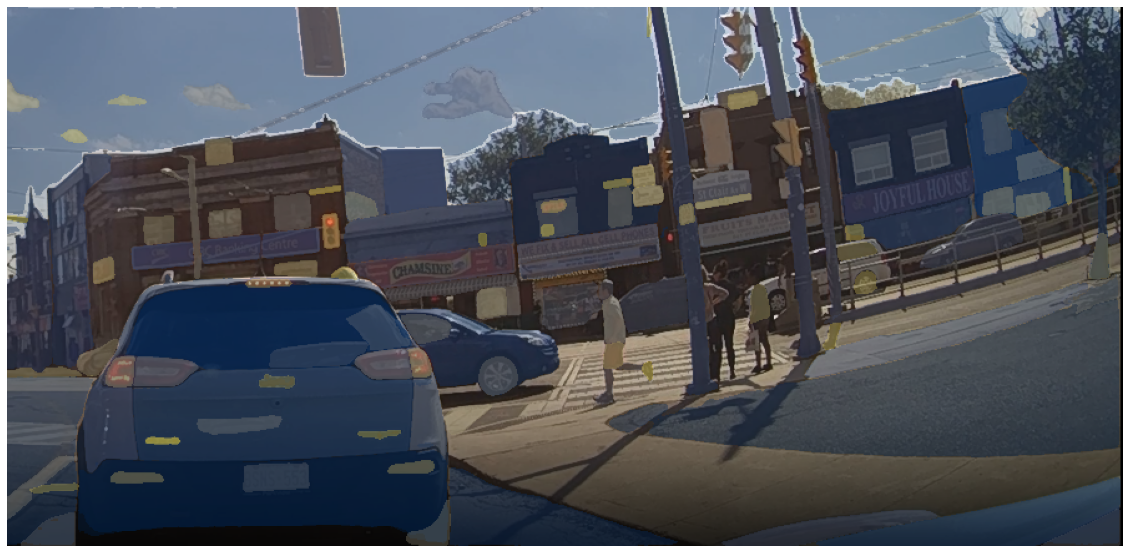

In [15]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show() 

## Automatic mask generation options

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks:

In [16]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,
    pred_iou_thresh=0.86,
    stability_score_thresh=0.92,
    crop_n_layers=1,
    crop_n_points_downscale_factor=2,
    min_mask_region_area=100,  # Requires open-cv to run post-processing
)

In [18]:
masks2 = mask_generator_2.generate(image)

In [19]:
len(masks2)

246

In [20]:
color_mask = np.random.random((1, 3)).tolist()
color_mask


[[0.5817645089783171, 0.11477517500208778, 0.0541423969451722]]

This results in each mask being displayed in a randomly chosen color which helps differentiate between them. It's important to note that the color of a mask does not convey any information about the mask or corresponding segment itself - it's purely for visual distinction.

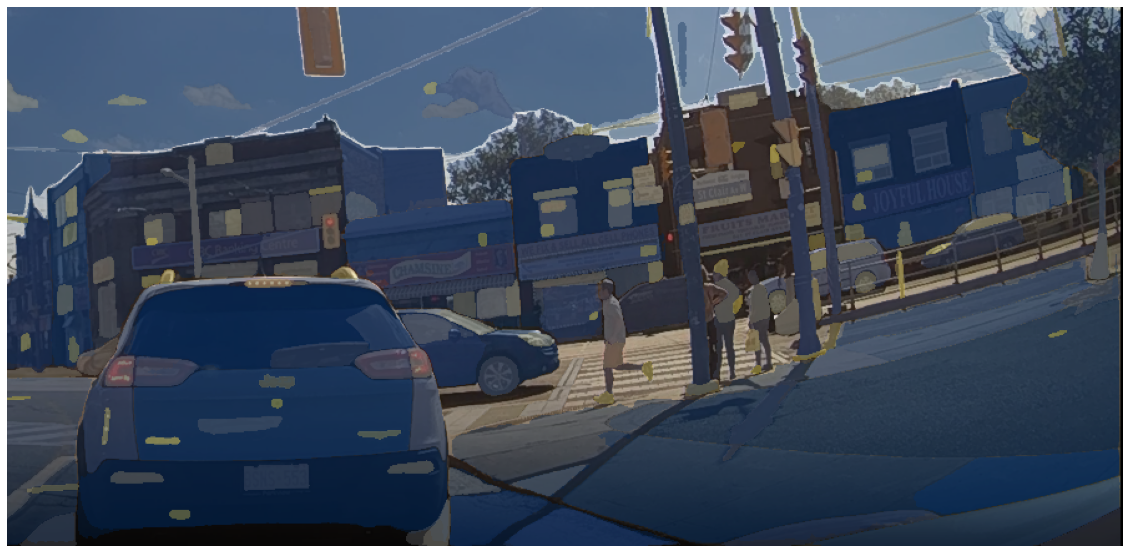

In [21]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks2)
plt.axis('off')
plt.show() 

In [ ]:
import torchvision.transforms as T
import os
from PIL import Image

# other necessary loading code is hidden

# Directory where the images are stored
input_dir = 'selected'

# Directory where the masked images will be saved
output_dir = 'masked'
os.makedirs(output_dir, exist_ok=True)

# Process all images in the directory
for filename in os.listdir(input_dir):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        image_path = os.path.join(input_dir, filename)
        output_path = os.path.join(output_dir, filename)

        if not os.path.exists(output_path):
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # don't need image transfrom

            # Generate masks
            masks = mask_generator.generate(image)

            # Create figure and show the original image
            plt.figure(figsize=(16,9))
            plt.imshow(image)
            show_anns(masks)

            # Save the current figure to the output directory
            plt.savefig(output_path)
            plt.close()